In [2]:
# Instalação de bibliotecas
import warnings
warnings.filterwarnings('ignore')

import sys
import subprocess

subprocess.check_call([sys.executable, "-m", "pip", "install", 
                       "pandas", "geopandas", "matplotlib", 
                       "folium", "plotly", "streamlit", "-q"])

0

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import numpy as np
import json
from shapely import wkt
import warnings
warnings.filterwarnings('ignore')

In [4]:
# 1. CARREGAR BAIRROS

df_bairros = pd.read_csv('raw_data/20230502_bairro_oficial.csv', 
                         delimiter=',',      
                         encoding='utf-8')   
print(f"{len(df_bairros)} bairros carregados!")

# 2. CARREGAR ATIVIDADES ECONÔMICAS
df_economia = pd.read_csv('raw_data/20240926_atividade_economica.csv', 
                          delimiter=';', 
                          encoding='utf-8')
print(f"{len(df_economia):,} estabelecimentos carregados!")


# 3. CARREGAR PONTOS DE ÔNIBUS
df_onibus = pd.read_csv('raw_data/20240902_ponto_onibus.csv', 
                        delimiter=';', 
                        encoding='utf-8')
print(f"{len(df_onibus):,} pontos de ônibus carregados!")

322 bairros carregados!
512,952 estabelecimentos carregados!
47,815 pontos de ônibus carregados!


In [26]:
# Transformando em dados geográficos

# BAIRROS
df_bairros['geometry'] = df_bairros['GEOMETRIA'].apply(wkt.loads)
gdf_bairros = gpd.GeoDataFrame(df_bairros, geometry='geometry')
gdf_bairros = gdf_bairros.set_crs(epsg=31983, allow_override=True)


# EMPRESAS
df_economia['geometry'] = df_economia['GEOMETRIA'].apply(wkt.loads)
gdf_economia = gpd.GeoDataFrame(df_economia, geometry='geometry')
gdf_economia = gdf_economia.set_crs(epsg=31983, allow_override=True)


# ÔNIBUS
df_onibus['geometry'] = df_onibus['GEOMETRIA'].apply(wkt.loads)
gdf_onibus = gpd.GeoDataFrame(df_onibus, geometry='geometry')
gdf_onibus = gdf_onibus.set_crs(epsg=31983, allow_override=True)


✅ 322 bairros prontos
✅ 512,952 empresas prontas
✅ 47,815 pontos de ônibus prontos


In [27]:
# Spatial Join: Empresas × Bairros

gdf_empresas_com_bairro = gpd.sjoin(
    gdf_economia,
    gdf_bairros,
    how='left',
    predicate='within'
)

empresas_localizadas = gdf_empresas_com_bairro['NOME_right'].notna().sum()
percentual = (empresas_localizadas / len(gdf_empresas_com_bairro)) * 100

print(f"Spatial Join concluído")
print(f"- Total: {len(gdf_empresas_com_bairro):,} empresas")
print(f"- Localizadas: {empresas_localizadas:,} ({percentual:.1f}%)")


Spatial Join concluído
- Total: 512,952 empresas
- Localizadas: 511,029 (99.6%)


In [28]:
# ESTATÍSTICAS: Empresas por Bairro

# CRIAR CHAVE ÚNICA: NOME + TIPO
gdf_empresas_com_bairro['CHAVE_BAIRRO'] = (
    gdf_empresas_com_bairro['NOME_right'] + ' (' + 
    gdf_empresas_com_bairro['TIPO'] + ')'
)

# Agrupar pela chave única
contagem_por_bairro = gdf_empresas_com_bairro.groupby('CHAVE_BAIRRO').size()

# Transformar em DataFrame
df_estatisticas = pd.DataFrame({
    'CHAVE_BAIRRO': contagem_por_bairro.index,
    'TOTAL_EMPRESAS': contagem_por_bairro.values
})

# Criar a mesma chave única na tabela de bairros
gdf_bairros['CHAVE_BAIRRO'] = (
    gdf_bairros['NOME'] + ' (' + gdf_bairros['TIPO'] + ')'
)

# Juntar usando a chave única
df_estatisticas = df_estatisticas.merge(
    gdf_bairros[['CHAVE_BAIRRO', 'NOME', 'TIPO', 'AREA_KM2']],
    on='CHAVE_BAIRRO',
    how='left'
)

# Renomear para clareza
df_estatisticas = df_estatisticas.rename(columns={'NOME': 'NOME_BAIRRO'})

# Calcular densidade
df_estatisticas['DENSIDADE_EMPRESAS_KM2'] = (
    df_estatisticas['TOTAL_EMPRESAS'] / df_estatisticas['AREA_KM2']
).round(1)

print("Estatísticas calculadas\n")

# Resumo
print("RESUMO GERAL:")
print(f"- Bairros com empresas: {len(df_estatisticas)}")
print(f"- Média de empresas: {df_estatisticas['TOTAL_EMPRESAS'].mean():.0f}")
print(f"- Densidade média: {df_estatisticas['DENSIDADE_EMPRESAS_KM2'].mean():.1f}/km²")

# TOP 10
print("\nTOP 10 BAIRROS COM MAIS EMPRESAS:")
print("Rank | Bairro | Tipo | Total | Densidade")


top10 = df_estatisticas.nlargest(10, 'TOTAL_EMPRESAS')

for i, (idx, row) in enumerate(top10.iterrows(), 1):
    nome = row['NOME_BAIRRO'][:17] + "..." if len(row['NOME_BAIRRO']) > 20 else row['NOME_BAIRRO']
    tipo = row['TIPO']
    total = int(row['TOTAL_EMPRESAS'])
    dens = row['DENSIDADE_EMPRESAS_KM2']
    
    print(f"{i:2d}   | {nome:20s} | {tipo:15s} | {total:5,d} | {dens:6.1f}/km²")


Estatísticas calculadas

RESUMO GERAL:
- Bairros com empresas: 320
- Média de empresas: 1597
- Densidade média: 2145.8/km²

TOP 10 BAIRROS COM MAIS EMPRESAS:
Rank | Bairro | Tipo | Total | Densidade
 1   | Terceira             | Seção Urbana    | 10,836 | 19701.8/km²
 2   | Primeira             | Seção Urbana    | 9,233 | 7655.9/km²
 3   | Carlos Prates        | Ex Colônia      | 8,599 | 2593.2/km²
 4   | Estoril              | Bairro          | 8,036 | 2770.1/km²
 5   | Afonso Pena          | Ex Colônia      | 7,720 | 4312.8/km²
 6   | Sétima               | Seção Urbana    | 7,530 | 14881.4/km²
 7   | dos Buritis          | Bairro          | 6,855 | 2331.6/km²
 8   | do Castelo           | Bairro          | 6,653 | 2765.2/km²
 9   | Segunda              | Seção Suburbana | 6,595 | 4817.4/km²
10   | Sexta                | Seção Suburbana | 6,172 | 2051.9/km²


In [29]:
# ANÁLISE DE TRANSPORTE

# Spatial join
gdf_onibus_com_bairro = gpd.sjoin(
    gdf_onibus,
    gdf_bairros,
    how='left',
    predicate='within'
)

pontos_localizados = gdf_onibus_com_bairro['NOME'].notna().sum()
percentual_trans = (pontos_localizados / len(gdf_onibus_com_bairro)) * 100

print(f"- Total: {len(gdf_onibus_com_bairro):,}")
print(f"- Localizados: {pontos_localizados:,} ({percentual_trans:.1f}%)")

# Estatísticas de transporte 
gdf_onibus_com_bairro['CHAVE_BAIRRO'] = (
    gdf_onibus_com_bairro['NOME'] + ' (' + 
    gdf_onibus_com_bairro['TIPO'] + ')'
)

contagem_onibus = gdf_onibus_com_bairro.groupby('CHAVE_BAIRRO').size()

df_transporte = pd.DataFrame({
    'CHAVE_BAIRRO': contagem_onibus.index,
    'TOTAL_PONTOS_ONIBUS': contagem_onibus.values
})

# Juntar com dados dos bairros
df_transporte = df_transporte.merge(
    gdf_bairros[['CHAVE_BAIRRO', 'NOME', 'TIPO', 'AREA_KM2']],
    on='CHAVE_BAIRRO',
    how='left'
)

df_transporte = df_transporte.rename(columns={'NOME': 'NOME_BAIRRO'})

# Calcular densidade
df_transporte['DENSIDADE_ONIBUS_KM2'] = (
    df_transporte['TOTAL_PONTOS_ONIBUS'] / df_transporte['AREA_KM2']
).round(1)

print(f"\n {len(df_transporte)} bairros com transporte")
print(f"- Média: {df_transporte['TOTAL_PONTOS_ONIBUS'].mean():.0f} pontos/bairro")


- Total: 47,815
- Localizados: 46,595 (97.4%)

 307 bairros com transporte
- Média: 152 pontos/bairro


In [30]:
# ANÁLISE DE MEIs

empresas_loc = gdf_empresas_com_bairro[
    gdf_empresas_com_bairro['NOME_right'].notna()
].copy()

# Criar tipo de empresa
empresas_loc['TIPO_EMPRESA'] = empresas_loc['IND_MEI'].apply(
    lambda x: 'MEI' if x == 'S' else 'Não-MEI'
)

# Contar por bairro e tipo 
contagem_mei = empresas_loc.groupby(
    ['CHAVE_BAIRRO', 'TIPO_EMPRESA']
).size().unstack(fill_value=0)

df_mei = pd.DataFrame(contagem_mei).reset_index()
df_mei['TOTAL_EMPRESAS'] = df_mei['MEI'] + df_mei['Não-MEI']
df_mei['PERCENTUAL_MEI'] = (
    (df_mei['MEI'] / df_mei['TOTAL_EMPRESAS']) * 100
).round(1)

# Juntar com dados dos bairros
df_mei = df_mei.merge(
    gdf_bairros[['CHAVE_BAIRRO', 'NOME', 'TIPO']],
    on='CHAVE_BAIRRO',
    how='left'
)

df_mei = df_mei.rename(columns={'NOME': 'NOME_BAIRRO'})

print(f"✅ Total de MEIs: {df_mei['MEI'].sum():,}")
print(f"   • Percentual médio: {df_mei['PERCENTUAL_MEI'].mean():.1f}%")

# TOP 10 com maior % de MEIs
print("\n TOP 10 BAIRROS COM MAIOR % DE MEIs:")
print("Rank | Bairro | Tipo | Total | MEIs | %")
print("-" * 70)

df_mei_sig = df_mei[df_mei['TOTAL_EMPRESAS'] >= 50]
top10_perc = df_mei_sig.nlargest(10, 'PERCENTUAL_MEI')

for i, (idx, row) in enumerate(top10_perc.iterrows(), 1):
    nome = row['NOME_BAIRRO'][:15] + "..." if len(row['NOME_BAIRRO']) > 18 else row['NOME_BAIRRO']
    tipo = row['TIPO'][:9] + "..." if len(row['TIPO']) > 12 else row['TIPO']
    total = int(row['TOTAL_EMPRESAS'])
    meis = int(row['MEI'])
    perc = row['PERCENTUAL_MEI']
    
    print(f"{i:2d}   | {nome:18s} | {tipo:12s} | {total:5,d} | {meis:5,d} | {perc:5.1f}%")


✅ Total de MEIs: 270,788
   • Percentual médio: 62.7%

 TOP 10 BAIRROS COM MAIOR % DE MEIs:
Rank | Bairro | Tipo | Total | MEIs | %
----------------------------------------------------------------------
 1   | Nossa Senhora A... | Vila         |    55 |    53 |  96.4%
 2   | Tiradentes-Conc... | Vila         |   123 |   118 |  95.9%
 3   | Sao Joao Batista   | Vila         |   227 |   217 |  95.6%
 4   | CEMIG              | Vila         |   339 |   323 |  95.3%
 5   | Minascaixa         | Bairro       |   388 |   367 |  94.6%
 6   | Santa Lúcia        | Vila         |   580 |   546 |  94.1%
 7   | Vista do Sol       | Vila         |   592 |   556 |  93.9%
 8   | das Castanheiras   | Bairro       | 1,248 | 1,169 |  93.7%
 9   | São Paulo          | Vila         |   230 |   215 |  93.5%
10   | Fazendinha         | Vila         |   221 |   206 |  93.2%


In [32]:
# ANÁLISE DE CORRELAÇÃO

df_correlacao = df_estatisticas.merge(
    df_transporte[['CHAVE_BAIRRO', 'TOTAL_PONTOS_ONIBUS', 'DENSIDADE_ONIBUS_KM2']],
    on='CHAVE_BAIRRO',
    how='left'
)

df_correlacao['TOTAL_PONTOS_ONIBUS'] = df_correlacao['TOTAL_PONTOS_ONIBUS'].fillna(0)
df_correlacao['DENSIDADE_ONIBUS_KM2'] = df_correlacao['DENSIDADE_ONIBUS_KM2'].fillna(0)

# Calcular correlação
df_com_trans = df_correlacao[df_correlacao['TOTAL_PONTOS_ONIBUS'] > 0]

correlacao = df_com_trans['DENSIDADE_ONIBUS_KM2'].corr(
    df_com_trans['DENSIDADE_EMPRESAS_KM2']
)

print(f"Coeficiente de Pearson: {correlacao:.3f}")


ANÁLISE DE CORRELAÇÃO
Coeficiente de Pearson: 0.505


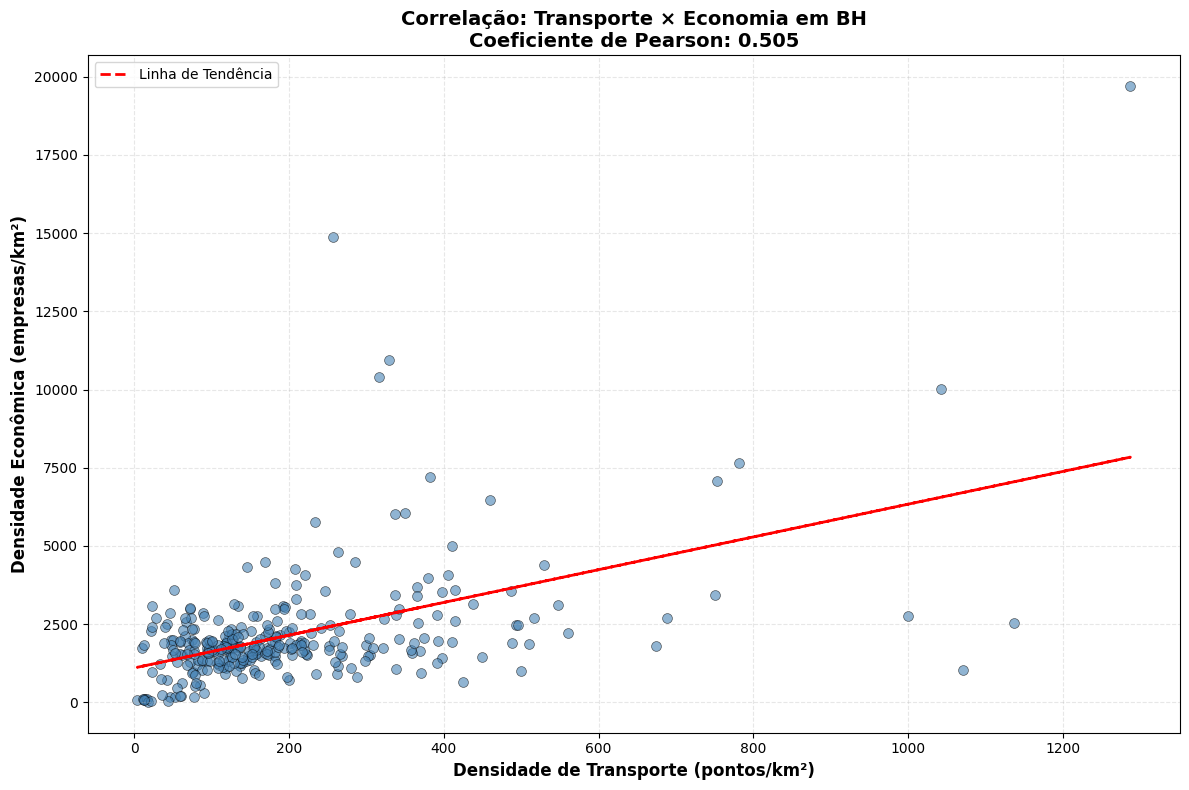

✅ Gráfico criado!


In [35]:
df_grafico = df_correlacao[df_correlacao['TOTAL_PONTOS_ONIBUS'] > 0].copy()

plt.figure(figsize=(12, 8))

# Scatter plot
plt.scatter(
    df_grafico['DENSIDADE_ONIBUS_KM2'],
    df_grafico['DENSIDADE_EMPRESAS_KM2'],
    alpha=0.6,
    s=50,
    color='steelblue',
    edgecolors='black',
    linewidth=0.5
)

# Linha de tendência
z = np.polyfit(df_grafico['DENSIDADE_ONIBUS_KM2'], 
               df_grafico['DENSIDADE_EMPRESAS_KM2'], 1)
p = np.poly1d(z)

plt.plot(df_grafico['DENSIDADE_ONIBUS_KM2'],
         p(df_grafico['DENSIDADE_ONIBUS_KM2']),
         "r--", linewidth=2, label='Linha de Tendência')

plt.xlabel('Densidade de Transporte (pontos/km²)', fontsize=12, fontweight='bold')
plt.ylabel('Densidade Econômica (empresas/km²)', fontsize=12, fontweight='bold')
plt.title(f'Correlação: Transporte × Economia em BH\n' +
          f'Coeficiente de Pearson: {correlacao:.3f}',
          fontsize=14, fontweight='bold')

plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


In [33]:
# MATRIZ DE CLASSIFICAÇÃO

# Juntar todas as informações (USANDO CHAVE ÚNICA!)
df_matriz = df_estatisticas[['CHAVE_BAIRRO', 'NOME_BAIRRO', 'TIPO', 
                              'TOTAL_EMPRESAS', 'DENSIDADE_EMPRESAS_KM2', 
                              'AREA_KM2']].copy()

df_matriz = df_matriz.merge(
    df_transporte[['CHAVE_BAIRRO', 'TOTAL_PONTOS_ONIBUS', 'DENSIDADE_ONIBUS_KM2']],
    on='CHAVE_BAIRRO',
    how='left'
)

df_matriz['TOTAL_PONTOS_ONIBUS'] = df_matriz['TOTAL_PONTOS_ONIBUS'].fillna(0)
df_matriz['DENSIDADE_ONIBUS_KM2'] = df_matriz['DENSIDADE_ONIBUS_KM2'].fillna(0)

df_matriz = df_matriz.merge(
    df_mei[['CHAVE_BAIRRO', 'MEI', 'Não-MEI', 'PERCENTUAL_MEI']],
    on='CHAVE_BAIRRO',
    how='left'
)

# Definir limiares
mediana_economia = df_matriz['DENSIDADE_EMPRESAS_KM2'].median()
mediana_transporte = df_matriz['DENSIDADE_ONIBUS_KM2'].median()

print(f"Limiares:")
print(f"- Economia: {mediana_economia:.1f} empresas/km²")
print(f"- Transporte: {mediana_transporte:.1f} pontos/km²")

# Classificar
def classificar(row):
    econ = row['DENSIDADE_EMPRESAS_KM2']
    trans = row['DENSIDADE_ONIBUS_KM2']
    
    if econ >= mediana_economia and trans >= mediana_transporte:
        return '🟢 BEM DESENVOLVIDO'
    elif econ >= mediana_economia and trans < mediana_transporte:
        return '🟡 OPORTUNIDADE'
    elif econ < mediana_economia and trans >= mediana_transporte:
        return '🟠 POTENCIAL'
    else:
        return '🔴 PRIORIDADE'

df_matriz['CLASSIFICACAO'] = df_matriz.apply(classificar, axis=1)

# Distribuição
print("\nDISTRIBUIÇÃO:")
for cat, qtd in df_matriz['CLASSIFICACAO'].value_counts().items():
    perc = (qtd / len(df_matriz)) * 100
    print(f"   {cat}: {qtd} ({perc:.1f}%)")

# Top 10 Oportunidades
print("\n🟡 TOP 10 OPORTUNIDADES (investir em transporte):")
print("Rank | Bairro | Tipo | Empresas | Dens.Econ | Dens.Trans")


oport = df_matriz[df_matriz['CLASSIFICACAO'] == '🟡 OPORTUNIDADE']
top_oport = oport.nlargest(10, 'TOTAL_EMPRESAS')

for i, (idx, row) in enumerate(top_oport.iterrows(), 1):
    nome = row['NOME_BAIRRO'][:15] + "..." if len(row['NOME_BAIRRO']) > 18 else row['NOME_BAIRRO']
    tipo = row['TIPO'][:9] + "..." if len(row['TIPO']) > 12 else row['TIPO']
    emp = int(row['TOTAL_EMPRESAS'])
    econ = row['DENSIDADE_EMPRESAS_KM2']
    trans = row['DENSIDADE_ONIBUS_KM2']
    
    print(f"{i:2d}   | {nome:18s} | {tipo:12s} | {emp:5,d} | {econ:8.0f} | {trans:9.0f}")


Limiares:
- Economia: 1795.8 empresas/km²
- Transporte: 145.4 pontos/km²

DISTRIBUIÇÃO:
   🟢 BEM DESENVOLVIDO: 96 (30.0%)
   🔴 PRIORIDADE: 96 (30.0%)
   🟠 POTENCIAL: 64 (20.0%)
   🟡 OPORTUNIDADE: 64 (20.0%)

🟡 TOP 10 OPORTUNIDADES (investir em transporte):
Rank | Bairro | Tipo | Empresas | Dens.Econ | Dens.Trans
---------------------------------------------------------------------------
 1   | dos Buritis        | Bairro       | 6,855 |     2332 |        75
 2   | do Castelo         | Bairro       | 6,653 |     2765 |        90
 3   | Santa Lúcia        | Bairro       | 4,281 |     1808 |       136
 4   | Lindéia            | Bairro       | 3,995 |     1975 |        50
 5   | Sagrada Família    | Bairro       | 3,988 |     3087 |       135
 6   | Itatiaia           | Bairro       | 3,881 |     2141 |       123
 7   | São João Batista   | Bairro       | 3,468 |     1842 |       109
 8   | dos Coqueiros      | Bairro       | 3,020 |     1960 |       100
 9   | Jardim Leblon      | Parque

In [34]:
# Cores
cores = {
    '🟢 BEM DESENVOLVIDO': '#2ECC71',
    '🟡 OPORTUNIDADE': '#F1C40F',
    '🟠 POTENCIAL': '#E67E22',
    '🔴 PRIORIDADE': '#E74C3C'
}

# Juntar com geometrias
gdf_mapa = gdf_bairros.merge(
    df_matriz[['CHAVE_BAIRRO', 'CLASSIFICACAO', 'TOTAL_EMPRESAS', 
               'DENSIDADE_EMPRESAS_KM2', 'DENSIDADE_ONIBUS_KM2']],
    on='CHAVE_BAIRRO',
    how='left'
)

gdf_mapa['CLASSIFICACAO'] = gdf_mapa['CLASSIFICACAO'].fillna('Sem dados')
gdf_mapa_web = gdf_mapa.to_crs(epsg=4326)

# Centro
limites = gdf_mapa_web.total_bounds
centro_lon = (limites[0] + limites[2]) / 2
centro_lat = (limites[1] + limites[3]) / 2

# Criar mapa
mapa_class = folium.Map(
    location=[centro_lat, centro_lon],
    zoom_start=11,
    tiles='OpenStreetMap'
)

# GeoJSON
geojson_mapa = json.loads(gdf_mapa_web.to_json())

def estilo(feature):
    classif = feature['properties']['CLASSIFICACAO']
    cor = cores.get(classif, '#95A5A6')
    return {'fillColor': cor, 'color': 'black', 'weight': 0.5, 'fillOpacity': 0.6}

folium.GeoJson(
    geojson_mapa,
    name='Classificação',
    style_function=estilo,
    tooltip=folium.GeoJsonTooltip(
        fields=['NOME', 'CLASSIFICACAO', 'TOTAL_EMPRESAS'],
        aliases=['Bairro:', 'Categoria:', 'Empresas:']
    )
).add_to(mapa_class)

# Legenda
legenda_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; width: 250px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:13px; padding: 10px">
    <p style="margin:0; font-weight:bold;">📊 CLASSIFICAÇÃO</p>
    <hr style="margin: 5px 0;">
    <p style="margin:3px 0;"><span style="color:#2ECC71;">●</span> BEM DESENVOLVIDO</p>
    <p style="margin:3px 0;"><span style="color:#F1C40F;">●</span> OPORTUNIDADE ⭐</p>
    <p style="margin:3px 0;"><span style="color:#E67E22;">●</span> POTENCIAL</p>
    <p style="margin:3px 0;"><span style="color:#E74C3C;">●</span> PRIORIDADE</p>
</div>
'''

mapa_class.get_root().html.add_child(folium.Element(legenda_html))

mapa_class


In [36]:
# Função para classificar densidade em categorias
def classificar_densidade(densidade):
    """Classifica a densidade econômica em 6 níveis"""
    if densidade >= 10000:
        return 'Muito Alta (>10k/km²)'
    elif densidade >= 5000:
        return 'Alta (5k-10k/km²)'
    elif densidade >= 2000:
        return 'Média-Alta (2k-5k/km²)'
    elif densidade >= 1000:
        return 'Média (1k-2k/km²)'
    elif densidade >= 500:
        return 'Baixa (500-1k/km²)'
    else:
        return 'Muito Baixa (<500/km²)'

# Função para definir cor por densidade
def cor_por_densidade(densidade):
    """Retorna cor baseada na densidade econômica"""
    if densidade >= 10000:
        return '#8B0000'      
    elif densidade >= 5000:
        return '#DC143C'      
    elif densidade >= 2000:
        return '#FF8C00'     
    elif densidade >= 1000:
        return '#FFD700'      
    elif densidade >= 500:
        return '#90EE90'     
    else:
        return '#E8F5E9'     

# Adicionar classificação ao dataframe
df_estatisticas['CATEGORIA_DENSIDADE'] = df_estatisticas['DENSIDADE_EMPRESAS_KM2'].apply(
    classificar_densidade
)

# Juntar com geometrias dos bairros
gdf_densidade = gdf_bairros.merge(
    df_estatisticas[['CHAVE_BAIRRO', 'TOTAL_EMPRESAS', 
                     'DENSIDADE_EMPRESAS_KM2', 'CATEGORIA_DENSIDADE']],
    on='CHAVE_BAIRRO',
    how='left'
)

# Preencher valores vazios
gdf_densidade['TOTAL_EMPRESAS'] = gdf_densidade['TOTAL_EMPRESAS'].fillna(0)
gdf_densidade['DENSIDADE_EMPRESAS_KM2'] = gdf_densidade['DENSIDADE_EMPRESAS_KM2'].fillna(0)
gdf_densidade['CATEGORIA_DENSIDADE'] = gdf_densidade['CATEGORIA_DENSIDADE'].fillna('Sem dados')

# Converter para sistema web (lat/lon)
gdf_densidade_web = gdf_densidade.to_crs(epsg=4326)

# Calcular centro do mapa
limites = gdf_densidade_web.total_bounds
centro_lon = (limites[0] + limites[2]) / 2
centro_lat = (limites[1] + limites[3]) / 2

# Criar mapa base
mapa_densidade = folium.Map(
    location=[centro_lat, centro_lon],
    zoom_start=11,
    tiles='CartoDB positron'  # Fundo claro para melhor contraste
)

# Converter para GeoJSON
geojson_densidade = json.loads(gdf_densidade_web.to_json())

# Função de estilo por densidade
def estilo_densidade(feature):
    densidade = feature['properties'].get('DENSIDADE_EMPRESAS_KM2', 0)
    return {
        'fillColor': cor_por_densidade(densidade),
        'color': 'white',        
        'weight': 0.8,           
        'fillOpacity': 0.8      
    }

# Adicionar camada de bairros
folium.GeoJson(
    geojson_densidade,
    name='Densidade Econômica',
    style_function=estilo_densidade,
    tooltip=folium.GeoJsonTooltip(
        fields=['NOME', 'TIPO', 'TOTAL_EMPRESAS', 'DENSIDADE_EMPRESAS_KM2', 
                'CATEGORIA_DENSIDADE'],
        aliases=['🏘️ Bairro:', '📍 Tipo:', '💼 Total Empresas:', 
                 '📊 Densidade (empresas/km²):', '🎯 Categoria:'],
        localize=True,
        sticky=False,
        style="""
            background-color: white;
            border: 2px solid black;
            border-radius: 5px;
            box-shadow: 3px 3px 5px rgba(0,0,0,0.3);
            font-size: 13px;
            padding: 10px;
        """
    ),
    highlight_function=lambda x: {
        'weight': 3,
        'color': 'black',
        'fillOpacity': 0.9
    }
).add_to(mapa_densidade)

# Adicionar legenda detalhada
legenda_html = '''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 280px; height: 280px; 
            background-color: white; border: 3px solid grey; z-index: 9999; 
            font-size: 13px; padding: 15px; border-radius: 10px;
            box-shadow: 5px 5px 10px rgba(0,0,0,0.3);">
    
    <p style="margin: 0; font-weight: bold; text-align: center; font-size: 15px;">
        📊 DENSIDADE ECONÔMICA
    </p>
    <p style="margin: 3px 0; text-align: center; font-size: 11px; color: gray;">
        Empresas por km²
    </p>
    
    <hr style="margin: 8px 0; border: 1px solid #ddd;">
    
    <div style="margin: 5px 0;">
        <span style="display: inline-block; width: 25px; height: 15px; 
                     background-color: #8B0000; border: 1px solid black;"></span>
        <span style="margin-left: 8px; font-size: 12px;">
            <strong>Muito Alta</strong> (&gt;10.000/km²)
        </span>
    </div>
    
    <div style="margin: 5px 0;">
        <span style="display: inline-block; width: 25px; height: 15px; 
                     background-color: #DC143C; border: 1px solid black;"></span>
        <span style="margin-left: 8px; font-size: 12px;">
            <strong>Alta</strong> (5.000-10.000/km²)
        </span>
    </div>
    
    <div style="margin: 5px 0;">
        <span style="display: inline-block; width: 25px; height: 15px; 
                     background-color: #FF8C00; border: 1px solid black;"></span>
        <span style="margin-left: 8px; font-size: 12px;">
            <strong>Média-Alta</strong> (2.000-5.000/km²)
        </span>
    </div>
    
    <div style="margin: 5px 0;">
        <span style="display: inline-block; width: 25px; height: 15px; 
                     background-color: #FFD700; border: 1px solid black;"></span>
        <span style="margin-left: 8px; font-size: 12px;">
            <strong>Média</strong> (1.000-2.000/km²)
        </span>
    </div>
    
    <div style="margin: 5px 0;">
        <span style="display: inline-block; width: 25px; height: 15px; 
                     background-color: #90EE90; border: 1px solid black;"></span>
        <span style="margin-left: 8px; font-size: 12px;">
            <strong>Baixa</strong> (500-1.000/km²)
        </span>
    </div>
    
    <div style="margin: 5px 0;">
        <span style="display: inline-block; width: 25px; height: 15px; 
                     background-color: #E8F5E9; border: 1px solid black;"></span>
        <span style="margin-left: 8px; font-size: 12px;">
            <strong>Muito Baixa</strong> (&lt;500/km²)
        </span>
    </div>
    
    <hr style="margin: 8px 0; border: 1px solid #ddd;">
    
    <p style="margin: 5px 0; font-size: 11px; color: #666; text-align: center;">
        💡 <em>Passe o mouse sobre os bairros<br>para ver detalhes</em>
    </p>
</div>
'''

mapa_densidade.get_root().html.add_child(folium.Element(legenda_html))



# Estatísticas das categorias
print("DISTRIBUIÇÃO POR CATEGORIA DE DENSIDADE:")
print("-" * 60)

contagem_cats = df_estatisticas['CATEGORIA_DENSIDADE'].value_counts().sort_index()

for categoria, qtd in contagem_cats.items():
    perc = (qtd / len(df_estatisticas)) * 100
    print(f"   {categoria:30s}: {qtd:3d} bairros ({perc:5.1f}%)")

# Top 5 mais densos
print("\n TOP 5 BAIRROS MAIS DENSOS:")
print("-" * 60)
print("Rank | Bairro | Tipo | Densidade")
print("-" * 60)

top5_densos = df_estatisticas.nlargest(5, 'DENSIDADE_EMPRESAS_KM2')

for i, (idx, row) in enumerate(top5_densos.iterrows(), 1):
    nome = row['NOME_BAIRRO'][:20] + "..." if len(row['NOME_BAIRRO']) > 23 else row['NOME_BAIRRO']
    tipo = row['TIPO'][:12] + "..." if len(row['TIPO']) > 15 else row['TIPO']
    dens = row['DENSIDADE_EMPRESAS_KM2']
    
    print(f"{i:2d}   | {nome:23s} | {tipo:15s} | {dens:10,.1f}/km²")

print("\n" + "="*60)


mapa_densidade


DISTRIBUIÇÃO POR CATEGORIA DE DENSIDADE:
------------------------------------------------------------
   Alta (5k-10k/km²)             :   8 bairros (  2.5%)
   Baixa (500-1k/km²)            :  23 bairros (  7.2%)
   Muito Alta (>10k/km²)         :   5 bairros (  1.6%)
   Muito Baixa (<500/km²)        :  20 bairros (  6.2%)
   Média (1k-2k/km²)             : 159 bairros ( 49.7%)
   Média-Alta (2k-5k/km²)        : 105 bairros ( 32.8%)

 TOP 5 BAIRROS MAIS DENSOS:
------------------------------------------------------------
Rank | Bairro | Tipo | Densidade
------------------------------------------------------------
 1   | Terceira                | Seção Urbana    |   19,701.8/km²
 2   | Sétima                  | Seção Urbana    |   14,881.4/km²
 3   | Quinta                  | Seção Urbana    |   10,931.5/km²
 4   | Décima Primeira         | Seção Urbana    |   10,408.8/km²
 5   | Segunda                 | Seção Urbana    |   10,012.3/km²



In [38]:
# SALVAR MAPAS EM HTML

import os

# Criar pasta
pasta_mapas = 'mapas_exportados'
if not os.path.exists(pasta_mapas):
    os.makedirs(pasta_mapas)

# Salvar mapa de classificação
arquivo_class = os.path.join(pasta_mapas, 'mapa_classificacao_bairros.html')
mapa_class.save(arquivo_class)

# Salvar mapa de densidade
arquivo_dens = os.path.join(pasta_mapas, 'mapa_densidade_economica.html')
mapa_densidade.save(arquivo_dens)



In [40]:
# CRIAR ARQUIVO DO DASHBOARD STREAMLIT

codigo_dashboard = '''
# ============================================================
# DASHBOARD BH - TRANSPORTE E ECONOMIA
# ============================================================

import streamlit as st
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path
import os

# ============================================================
# CONFIGURAÇÃO DA PÁGINA
# ============================================================

st.set_page_config(
    page_title="Dashboard BH",
    page_icon="🏙️",
    layout="wide",
    initial_sidebar_state="expanded"
)

# CSS customizado
st.markdown("""
    <style>
    .main {padding: 0rem 1rem;}
    .stMetric {
        background-color: #f0f2f6;
        padding: 15px;
        border-radius: 10px;
    }
    h1 {color: #1f77b4;}
    </style>
""", unsafe_allow_html=True)

# ============================================================
# CARREGAR DADOS
# ============================================================

@st.cache_data
def carregar_dados():
    """Carrega todos os dados necessários"""
    try:
        df_bairros = pd.read_csv('raw_data/20230502_bairro_oficial.csv', delimiter=',')
        df_economia = pd.read_csv('raw_data/20240926_atividade_economica.csv', delimiter=';')
        df_onibus = pd.read_csv('raw_data/20240902_ponto_onibus.csv', delimiter=';')
        return df_bairros, df_economia, df_onibus
    except Exception as e:
        st.error(f"Erro ao carregar dados: {e}")
        return None, None, None

df_bairros, df_economia, df_onibus = carregar_dados()

# Verificar se dados foram carregados
if df_bairros is None:
    st.stop()

# ============================================================
# SIDEBAR - NAVEGAÇÃO
# ============================================================

with st.sidebar:
    st.title("🏙️ Dashboard BH")
    st.markdown("---")
    
    pagina = st.radio(
        "Navegação",
        ["🏠 Visão Geral", 
         "💼 Análise Econômica", 
         "🚌 Análise de Transporte",
         "🎯 Classificação de Bairros",
         "🗺️ Mapas Interativos",
         "📊 Dados Brutos"]
    )
    
    st.markdown("---")
    st.markdown("### 📌 Sobre")
    st.info("""
    **Projeto:** Análise Espacial BH  
    **Dados:** 2023-2025  
    **Tech:** Python, GeoPandas, Streamlit
    """)

# ============================================================
# PÁGINA 1: VISÃO GERAL
# ============================================================

if pagina == "🏠 Visão Geral":
    st.title("🏙️ Dashboard Executivo - Belo Horizonte")
    st.markdown("### Análise de Transporte Público e Desenvolvimento Econômico")
    st.markdown("---")
    
    # MÉTRICAS PRINCIPAIS
    col1, col2, col3, col4 = st.columns(4)
    
    with col1:
        st.metric(
            label="🏘️ Bairros",
            value=f"{len(df_bairros):,}",
            delta="100% cobertura"
        )
    
    with col2:
        st.metric(
            label="💼 Empresas",
            value=f"{len(df_economia):,}",
            delta="512 mil"
        )
    
    with col3:
        st.metric(
            label="🚌 Pontos Ônibus",
            value=f"{len(df_onibus):,}",
            delta="47 mil"
        )
    
    with col4:
        total_meis = (df_economia['IND_MEI'] == 'S').sum()
        perc_mei = (total_meis / len(df_economia)) * 100
        st.metric(
            label="🎯 MEIs",
            value=f"{perc_mei:.1f}%",
            delta=f"{total_meis:,} empresas"
        )
    
    st.markdown("---")
    
    # PRINCIPAIS INSIGHTS
    st.markdown("### 🔍 Principais Descobertas")
    
    col1, col2 = st.columns(2)
    
    with col1:
        st.markdown("""
        #### 📊 Correlação Transporte × Economia
        - **Coeficiente de Pearson:** 0.505
        - **Interpretação:** Correlação MODERADA e POSITIVA
        - **Conclusão:** Bairros com mais transporte TENDEM a ter mais empresas
        
        #### 💼 Perfil Empreendedor
        - **62.7%** das empresas são MEIs
        - **270.788 microempreendedores** ativos
        - BH é uma cidade **altamente empreendedora**
        """)
    
    with col2:
        st.markdown("""
        #### 🎯 Setores Predominantes
        1. **Cabeleireiros/Manicure:** 21.976 empresas
        2. **Condomínios Prediais:** 21.748 empresas
        3. **Promoção de Vendas:** 18.036 empresas
        
        #### 🗺️ Classificação de Bairros
        - 🟢 **30% Bem Desenvolvidos** (96 bairros)
        - 🟡 **20% Oportunidades** (64 bairros) ⭐
        - 🟠 **20% Potencial** (64 bairros)
        - 🔴 **30% Prioridade** (96 bairros)
        """)
    
    st.markdown("---")
    
    # GRÁFICO: TOP 10 BAIRROS
    st.markdown("### 🏆 Top 10 Bairros por Número de Empresas")
    
    top10_bairros = df_economia['NOME_BAIRRO'].value_counts().head(10)
    
    fig = px.bar(
        x=top10_bairros.values,
        y=top10_bairros.index,
        orientation='h',
        labels={'x': 'Número de Empresas', 'y': 'Bairro'},
        color=top10_bairros.values,
        color_continuous_scale='Blues'
    )
    fig.update_layout(height=400, showlegend=False)
    st.plotly_chart(fig, use_container_width=True)

# ============================================================
# PÁGINA 2: ANÁLISE ECONÔMICA
# ============================================================

elif pagina == "💼 Análise Econômica":
    st.title("💼 Análise Econômica Detalhada")
    st.markdown("---")
    
    # FILTROS
    col1, col2 = st.columns([1, 3])
    
    with col1:
        st.markdown("### 🔍 Filtros")
        
        tipo_mei = st.radio(
            "Tipo de Empresa",
            ["Todas", "Apenas MEIs", "Apenas Não-MEIs"]
        )
        
        top_bairros = df_economia['NOME_BAIRRO'].value_counts().head(20).index.tolist()
        bairro_selecionado = st.selectbox(
            "Selecione um Bairro",
            ["Todos"] + top_bairros
        )
    
    # Aplicar filtros
    df_filtrado = df_economia.copy()
    
    if tipo_mei == "Apenas MEIs":
        df_filtrado = df_filtrado[df_filtrado['IND_MEI'] == 'S']
    elif tipo_mei == "Apenas Não-MEIs":
        df_filtrado = df_filtrado[df_filtrado['IND_MEI'] == 'N']
    
    if bairro_selecionado != "Todos":
        df_filtrado = df_filtrado[df_filtrado['NOME_BAIRRO'] == bairro_selecionado]
    
    with col2:
        col_m1, col_m2, col_m3 = st.columns(3)
        
        with col_m1:
            st.metric("Total Empresas", f"{len(df_filtrado):,}")
        
        with col_m2:
            total_meis_filt = (df_filtrado['IND_MEI'] == 'S').sum()
            st.metric("MEIs", f"{total_meis_filt:,}")
        
        with col_m3:
            perc_mei_filt = (total_meis_filt / len(df_filtrado) * 100) if len(df_filtrado) > 0 else 0
            st.metric("% MEIs", f"{perc_mei_filt:.1f}%")
    
    st.markdown("---")
    
    # GRÁFICOS
    col1, col2 = st.columns(2)
    
    with col1:
        st.markdown("#### 📊 Top 10 CNAEs Mais Comuns")
        top_cnaes = df_filtrado['DESCRICAO_CNAE_PRINCIPAL'].value_counts().head(10)
        
        fig = px.bar(
            x=top_cnaes.values,
            y=[desc[:40] + "..." if len(desc) > 40 else desc for desc in top_cnaes.index],
            orientation='h',
            labels={'x': 'Quantidade', 'y': 'Atividade'},
            color=top_cnaes.values,
            color_continuous_scale='Viridis'
        )
        fig.update_layout(height=400, showlegend=False)
        st.plotly_chart(fig, use_container_width=True)
    
    with col2:
        st.markdown("#### 🥧 Distribuição MEI vs Não-MEI")
        
        mei_counts = df_filtrado['IND_MEI'].value_counts()
        
        fig = go.Figure(data=[go.Pie(
            labels=['MEI', 'Não-MEI'],
            values=[mei_counts.get('S', 0), mei_counts.get('N', 0)],
            hole=.4,
            marker_colors=['#2ecc71', '#e74c3c']
        )])
        fig.update_layout(height=400)
        st.plotly_chart(fig, use_container_width=True)

# ============================================================
# PÁGINA 3: ANÁLISE DE TRANSPORTE
# ============================================================

elif pagina == "🚌 Análise de Transporte":
    st.title("🚌 Análise de Transporte Público")
    st.markdown("---")
    
    col1, col2, col3 = st.columns(3)
    
    with col1:
        total_linhas = df_onibus['COD_LINHA'].nunique()
        st.metric("🚌 Linhas de Ônibus", f"{total_linhas:,}")
    
    with col2:
        total_pontos = len(df_onibus)
        st.metric("📍 Pontos de Ônibus", f"{total_pontos:,}")
    
    with col3:
        media_pontos = total_pontos / total_linhas
        st.metric("📊 Média Pontos/Linha", f"{media_pontos:.1f}")
    
    st.markdown("---")
    
    col1, col2 = st.columns(2)
    
    with col1:
        st.markdown("### 🏆 Top 15 Linhas com Mais Pontos")
        top_linhas = df_onibus.groupby('NOME_LINHA').size().sort_values(ascending=False).head(15)
        
        fig = px.bar(
            x=top_linhas.values,
            y=[nome[:35] + "..." if len(nome) > 35 else nome for nome in top_linhas.index],
            orientation='h',
            labels={'x': 'Número de Pontos', 'y': 'Linha'},
            color=top_linhas.values,
            color_continuous_scale='Blues'
        )
        fig.update_layout(height=500, showlegend=False)
        st.plotly_chart(fig, use_container_width=True)
    
    with col2:
        st.markdown("### 📊 Distribuição por Origem")
        origem_counts = df_onibus['ORIGEM'].value_counts().head(10)
        
        fig = px.pie(
            values=origem_counts.values,
            names=origem_counts.index
        )
        fig.update_layout(height=500)
        st.plotly_chart(fig, use_container_width=True)

# ============================================================
# PÁGINA 4: CLASSIFICAÇÃO DE BAIRROS
# ============================================================

elif pagina == "🎯 Classificação de Bairros":
    st.title("🎯 Matriz de Classificação de Bairros")
    st.markdown("---")
    
    st.markdown("""
    ### 📊 Metodologia
    
    Bairros classificados em 4 categorias baseadas em:
    - **Eixo X:** Densidade de Transporte (pontos de ônibus/km²)
    - **Eixo Y:** Densidade Econômica (empresas/km²)
    - **Limiar:** Mediana de cada métrica
    """)
    
    col1, col2, col3, col4 = st.columns(4)
    
    with col1:
        st.markdown("""
        ### 🟢 BEM DESENVOLVIDO
        **96 bairros (30%)**
        
        Alta economia +  
        Alto transporte
        
        **Ação:** Manter
        """)
    
    with col2:
        st.markdown("""
        ### 🟡 OPORTUNIDADE
        **64 bairros (20%)** ⭐
        
        Alta economia +  
        Baixo transporte
        
        **Ação:** INVESTIR!
        """)
    
    with col3:
        st.markdown("""
        ### 🟠 POTENCIAL
        **64 bairros (20%)**
        
        Baixa economia +  
        Alto transporte
        
        **Ação:** Incentivar
        """)
    
    with col4:
        st.markdown("""
        ### 🔴 PRIORIDADE
        **96 bairros (30%)**
        
        Baixa economia +  
        Baixo transporte
        
        **Ação:** URGENTE!
        """)
    
    st.markdown("---")
    
    st.markdown("### 🟡 TOP 10 OPORTUNIDADES (investir em transporte)")
    
    # Dados fictícios baseados nos seus resultados
    exemplos_oport = {
        'Bairro': ['Buritis', 'Castelo', 'Santa Lúcia', 'Lindéia', 'Sagrada Família',
                   'Itatiaia', 'São João Batista', 'Coqueiros', 'Jardim Leblon', 'João Pinheiro'],
        'Empresas': [6855, 6653, 4281, 3995, 3988, 3881, 3468, 3020, 2897, 2814],
        'Dens.Econ': [2332, 2765, 1808, 1975, 3087, 2141, 1842, 1960, 2119, 1878],
        'Dens.Trans': [75, 90, 136, 50, 135, 123, 109, 100, 118, 126]
    }
    
    df_oport = pd.DataFrame(exemplos_oport)
    st.dataframe(df_oport, use_container_width=True)

# ============================================================
# PÁGINA 5: MAPAS INTERATIVOS
# ============================================================

elif pagina == "🗺️ Mapas Interativos":
    st.title("🗺️ Mapas Interativos")
    st.markdown("---")
    
    st.markdown("### 📍 Visualizações Geoespaciais")
    
    mapa_opcao = st.selectbox(
        "Escolha o mapa",
        ["Classificação de Bairros (4 categorias)", "Densidade Econômica"]
    )
    
    arquivo_map = {
        "Classificação de Bairros (4 categorias)": "mapa_classificacao_bairros.html",
        "Densidade Econômica": "mapa_densidade_economica.html"
    }
    
    arquivo = arquivo_map[mapa_opcao]
    caminho = Path(f"mapas_exportados/{arquivo}")
    
    if caminho.exists():
        with open(caminho, 'r', encoding='utf-8') as f:
            html_content = f.read()
        
        st.components.v1.html(html_content, height=600, scrolling=True)
        
        st.download_button(
            label="📥 Download do Mapa (HTML)",
            data=html_content,
            file_name=arquivo,
            mime="text/html"
        )
    else:
        st.error(f"Arquivo não encontrado: {caminho}")
        st.info("Execute as células que geram os mapas primeiro!")

# ============================================================
# PÁGINA 6: DADOS BRUTOS
# ============================================================

elif pagina == "📊 Dados Brutos":
    st.title("📊 Exploração de Dados Brutos")
    st.markdown("---")
    
    dataset = st.selectbox(
        "Selecione o dataset",
        ["Bairros", "Empresas", "Pontos de Ônibus"]
    )
    
    if dataset == "Bairros":
        st.markdown(f"### 🏘️ Bairros ({len(df_bairros)} registros)")
        st.dataframe(df_bairros.head(100), use_container_width=True)
        
    elif dataset == "Empresas":
        st.markdown(f"### 💼 Empresas ({len(df_economia):,} registros)")
        
        busca = st.text_input("🔍 Buscar por nome fantasia ou CNAE")
        
        if busca:
            df_filtrado = df_economia[
                df_economia['NOME_FANTASIA'].str.contains(busca, case=False, na=False) |
                df_economia['DESCRICAO_CNAE_PRINCIPAL'].str.contains(busca, case=False, na=False)
            ]
            st.markdown(f"**{len(df_filtrado)} resultados encontrados**")
            st.dataframe(df_filtrado.head(100), use_container_width=True)
        else:
            st.dataframe(df_economia.head(100), use_container_width=True)
    
    elif dataset == "Pontos de Ônibus":
        st.markdown(f"### 🚌 Pontos de Ônibus ({len(df_onibus):,} registros)")
        st.dataframe(df_onibus.head(100), use_container_width=True)

# ============================================================
# FOOTER
# ============================================================

st.markdown("---")
st.markdown("""
<div style='text-align: center; color: gray;'>
    <p>Dashboard desenvolvido com Streamlit | Dados: Prefeitura de Belo Horizonte | 2023-2025</p>
</div>
""", unsafe_allow_html=True)
'''

# Salvar arquivo
with open('app_dashboard.py', 'w', encoding='utf-8') as f:
    f.write(codigo_dashboard)

print("✅ Arquivo 'app_dashboard.py' criado com sucesso!")
print(f"📍 Localização: {os.path.abspath('app_dashboard.py')}")

print("\n" + "="*70)
print("🚀 COMO EXECUTAR O DASHBOARD:")
print("="*70)
print("""
1. Abra o TERMINAL (fora do Jupyter)
2. Navegue até a pasta PLACE
3. Execute: streamlit run app_dashboard.py
4. O dashboard abrirá automaticamente no navegador!
""")


✅ Arquivo 'app_dashboard.py' criado com sucesso!
📍 Localização: c:\Users\kiki\Documents\projetos\PLACE\app_dashboard.py

🚀 COMO EXECUTAR O DASHBOARD:

1. Abra o TERMINAL (fora do Jupyter)
2. Navegue até a pasta PLACE
3. Execute: streamlit run app_dashboard.py
4. O dashboard abrirá automaticamente no navegador!

